##PyTorch Implementation for Mushroom Image Classification with an arbitrary CNN model

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

#image_folder = '/content/drive/My Drive/data/data/'

# Define your dataset directory (adjust this path to your Google Drive location)
data_dir = '/content/drive/My Drive/data/data'

Mounted at /content/drive


In [26]:
# Count all valid images
class_folders = os.listdir(data_dir)

image_count = 0

for class_name in class_folders:
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    for file in os.listdir(class_path):
      if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_count += 1
print(f"Total images found: {image_count}")



Total images found: 3122


In [5]:
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the mushroom class folders
            transform (callable, optional): Optional transform to be applied
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        """Helper to load all valid image paths and their labels"""
        samples = []
        for class_name in self.classes:
            class_idx = self.class_to_idx[class_name]
            class_path = os.path.join(self.root_dir, class_name)

            # Skip if not a directory
            if not os.path.isdir(class_path):
                continue

            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_path, file_name)
                    samples.append((img_path, class_idx))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            # Open image and convert to RGB (handles grayscale images)
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            # Return a placeholder if image is corrupted
            dummy_img = torch.zeros(3, 224, 224)  # Adjust size as needed
            return dummy_img, label


In [6]:

# Define your transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [7]:
# Initialize dataset
custom_dataset = MushroomDataset(root_dir=data_dir, transform=data_transforms)


print(f"Total classes: {len(custom_dataset.classes)}")
print(f"Total images: {len(custom_dataset)}")


# Split into train/val/test (80%/10%/10%)
train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")



Total classes: 215
Total images: 3122
Train: 2497, Val: 312, Test: 313


torch.Size([3, 224, 224])


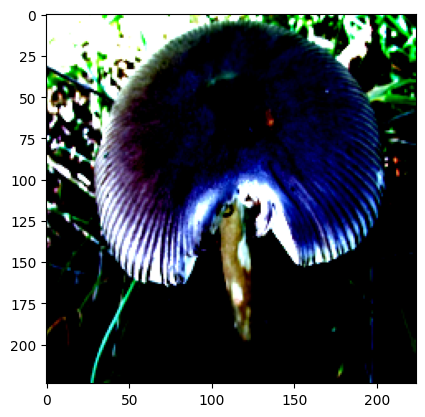

In [8]:
index = np.random.randint(1,len(train_dataset))

img = train_dataset.__getitem__(index)[0]
print(img.shape)

plt.imshow(img.permute(1,2,0))

In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Number of Train batches: ", len(train_loader))
print("Number of val   batches: ", len(val_loader))
print("Number of Test  batches: ", len(test_loader))

# Verify a batch
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")  # Should be [32, 3, 224, 224]
    break

Number of Train batches:  79
Number of val   batches:  10
Number of Test  batches:  10
Batch shape: torch.Size([32, 3, 224, 224])


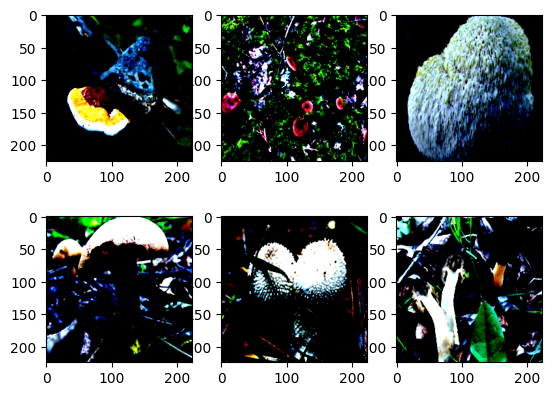

In [10]:
for i in range(6):
     plt.subplot(2,3,i+1)
     plt.imshow(images[i].permute(1,2,0))

plt.show()

#Creating model

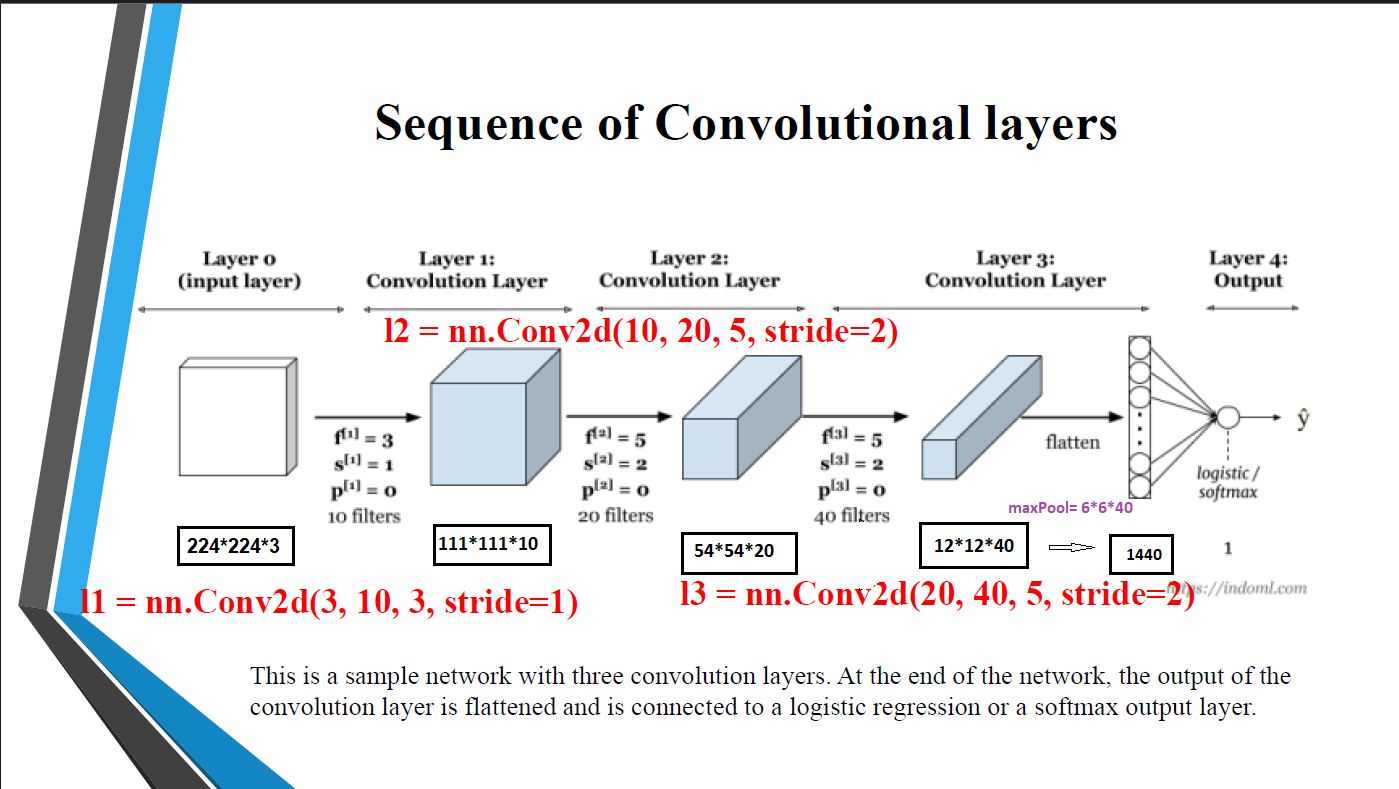

In [11]:
# Define the Neural Network
class MyConvNet(nn.Module):

    def __init__(self,n_classes):
        super(MyConvNet, self).__init__()

        # Layer 1: Input 224x224 -> Output 111x111
        self.layer1 = nn.Sequential(
                                      nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3, padding=0,stride=1), # (224-3)/1 +1 = 222
                                      nn.BatchNorm2d(10),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2) # 222 -> 111
                                   )

        # Layer 2: Input 111x111 -> Output 54x54
        self.layer2 = nn.Sequential(
                                      nn.Conv2d(in_channels=10,out_channels=20, kernel_size=5, padding=0, stride=2), # (111-5)/2 +1 = 54
                                      nn.BatchNorm2d(20),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2) # 54 -> 27
                                    )

        # Layer 3: Input 27x27 -> Output 12x12
        self.layer3 = nn.Sequential(
                                      nn.Conv2d(in_channels=20,out_channels=40, kernel_size=5, padding=0, stride=2), # (27-5)/2 +1 = 11
                                      nn.BatchNorm2d(40),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, ceil_mode=True) # 11 -> 6 (using ceil_mode)
                                    )
        #input size (40*6*6 = 1440)
        self.linear1 = nn.Linear(40*6*6, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        # Layer 1
        x = self.layer1(x)

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        x = self.layer3(x)

        # Layer 4,5: fully connected layer
        x = x.view(-1,40*6*6)
        x = self.linear1(x)
        out = self.softmax(x)
        return out

In [12]:
input_size = (3, 224, 224)
n_class = len(custom_dataset.classes)
model = MyConvNet(n_class).to(device)
print(model)

MyConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (linear1): Linear(in_features=1440, out_features=215, bias=True)
  (softmax): Softmax(dim=1)
)


In [13]:
from torchsummary import summary
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             280
       BatchNorm2d-2         [-1, 10, 222, 222]              20
              ReLU-3         [-1, 10, 222, 222]               0
         MaxPool2d-4         [-1, 10, 111, 111]               0
            Conv2d-5           [-1, 20, 54, 54]           5,020
       BatchNorm2d-6           [-1, 20, 54, 54]              40
              ReLU-7           [-1, 20, 54, 54]               0
         MaxPool2d-8           [-1, 20, 27, 27]               0
            Conv2d-9           [-1, 40, 12, 12]          20,040
      BatchNorm2d-10           [-1, 40, 12, 12]              80
             ReLU-11           [-1, 40, 12, 12]               0
        MaxPool2d-12             [-1, 40, 6, 6]               0
           Linear-13                  [-1, 215]         309,815
          Softmax-14                  [

In [14]:
# Loss function (better for classification than MSE)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
# Hyperparameters
num_epochs = 10
best_val_acc = 0.0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    n_correct_train = 0
    n_samples_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        n_samples_train += labels.size(0)
        n_correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Print batch progress
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    # Training metrics
    train_acc = 100.0 * n_correct_train / n_samples_train
    train_loss = running_loss / len(train_loader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    n_correct_val = 0
    n_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            n_samples_val += labels.size(0)
            n_correct_val += (predicted == labels).sum().item()
            val_loss += loss.item()

    # Validation metrics
    val_acc = 100.0 * n_correct_val / n_samples_val
    val_loss = val_loss / len(val_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mushroom_model.pth')
        print(f'New best model saved with val_acc: {val_acc:.2f}%')

    # Epoch summary
    print(f'\nEpoch [{epoch+1}/{num_epochs}] => '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


New best model saved with val_acc: 5.45%

Epoch [1/10] => Train Loss: 5.1136, Train Acc: 27.19% | Val Loss: 5.3264, Val Acc: 5.45%

Epoch [2/10] => Train Loss: 5.0806, Train Acc: 29.20% | Val Loss: 5.3269, Val Acc: 5.45%

Epoch [3/10] => Train Loss: 5.0856, Train Acc: 30.04% | Val Loss: 5.3257, Val Acc: 5.45%
New best model saved with val_acc: 7.69%

Epoch [4/10] => Train Loss: 5.0750, Train Acc: 31.00% | Val Loss: 5.3098, Val Acc: 7.69%

Epoch [5/10] => Train Loss: 5.0648, Train Acc: 32.08% | Val Loss: 5.3076, Val Acc: 7.05%

Epoch [6/10] => Train Loss: 5.0568, Train Acc: 32.68% | Val Loss: 5.3174, Val Acc: 6.09%

Epoch [7/10] => Train Loss: 5.0366, Train Acc: 33.44% | Val Loss: 5.3228, Val Acc: 5.77%

Epoch [8/10] => Train Loss: 5.0264, Train Acc: 34.72% | Val Loss: 5.3234, Val Acc: 6.09%

Epoch [9/10] => Train Loss: 5.0305, Train Acc: 35.28% | Val Loss: 5.3123, Val Acc: 7.05%
New best model saved with val_acc: 8.65%

Epoch [10/10] => Train Loss: 5.0212, Train Acc: 36.08% | Val Loss:

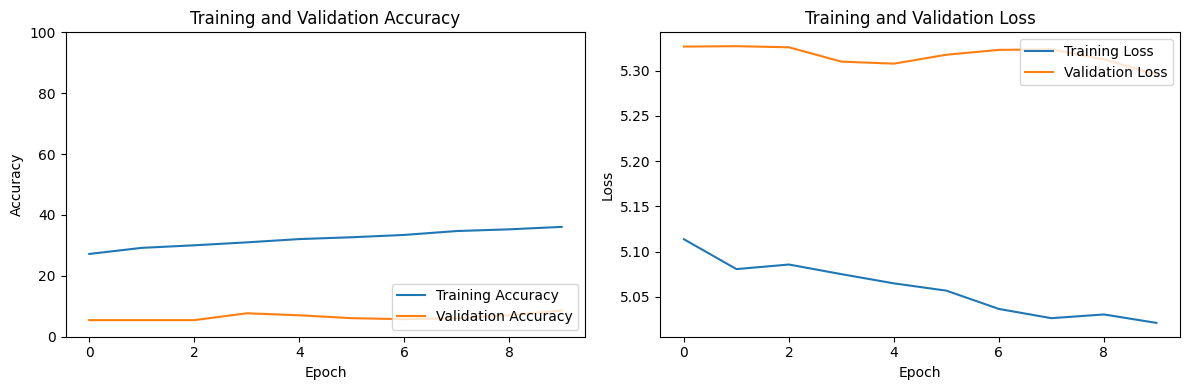

In [20]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 100])  # 0-100% range
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [21]:
# 1. Load your best saved model
model.load_state_dict(torch.load('best_mushroom_model.pth'))
model.eval()  # Set to evaluation mode


MyConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (linear1): Linear(in_features=1440, out_features=215, bias=True)
  (softmax): Softmax(dim=1)
)

In [22]:
# 2. Initialize metrics
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

# 3. Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()

        # Store for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Calculate final metrics
test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total

print(f'\nTest Results:')
print(f'Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%')
print(f'Correct: {correct}/{total}')



Test Results:
Loss: 5.2924 | Accuracy: 8.95%
Correct: 28/313
